**Building a Sentiment Analysis Pipeline with Web Scraping, NLTK, Transformers, and TextBlob**

In [40]:
!pip install requests

Setting Up the Environment and Importing Libraries

In [41]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from textblob import TextBlob
import nltk

# Download the VADER Lexicon
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Keyword-Based Headline Filtering Function

In [25]:
def find_headlines_by_keywords(headlines, keywords):
    matching_headlines = []

    for headline in headlines:
        if any(keyword.lower() in headline.lower() for keyword in keywords):
            matching_headlines.append(headline)

    return matching_headlines

Web Scraping Function for Extracting News Headlines and Dates

In [7]:
def scrape_news(url, max_pages=10):
    all_headlines = []
    all_dates = []

    for page_number in range(1, max_pages + 1):
        page_url = f"{url}/page/{page_number}/"
        response = requests.get(page_url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Select headlines and dates
            headlines_elements = soup.select('h2.entry-title span.dfm-title.metered')
            dates_elements = soup.select('div.entry-meta time')

            # Additional selectors for premium headlines and dates
            headlines_elements_premium = soup.select('h2.entry-title span.dfm-title.premium')
            dates_elements_premium = soup.select('div.entry-meta time')

            # Combine the two sets of headlines and dates
            headlines = headlines_elements + headlines_elements_premium
            dates = dates_elements + dates_elements_premium

            # Extracted data for the current page
            extracted_headlines = [headline.get_text() for headline in headlines]
            extracted_dates = [date['datetime'] for date in dates]

            # Append the data to the overall lists
            all_headlines.extend(extracted_headlines)
            all_dates.extend(extracted_dates)
        else:
            print(f"Failed to retrieve data from page {page_number}")

    return all_headlines, all_dates

Exporting Data to CSV and Preprocessing for Sentiment Analysis

In [8]:
def write_to_csv(all_headlines_list, all_dates_list, csv_filename='crime_news.csv'):
    with open(csv_filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Headline', 'Date'])

        for headline, date in zip(all_headlines_list, all_dates_list):
            writer.writerow([headline, date])

    # Convert CSV to DataFrame
    df = pd.read_csv(csv_filename)

    # Step 3: Clean up headlines
    df['Headline'] = clean_headlines(df['Headline'])

    # Step 4: Analyze Sentiments
    analyze_and_add_sentiments(df)

    return df

Cleaning Headlines: Removing Whitespace, Newlines, and Tabs

In [9]:
def clean_headlines(headlines):
    # Remove leading and trailing whitespaces, newline characters, and tabs
    cleaned_headlines = headlines.str.replace(r'\n|\t', '').str.strip()
    return cleaned_headlines

Sentiment Analysis and Adding Scores to DataFrame

In [30]:
def analyze_and_add_sentiments(df):
    #Analyze Sentiments using VADER
    vader_sentiments, vader_scores = analyze_headline_sentiments_vader(df['Headline'])
    df['VADER_Sentiment'] = vader_sentiments
    df['VADER_Score'] = vader_scores


    #Analyze Sentiments using TextBlob
    textblob_sentiments, textblob_scores = analyze_headline_sentiments_textblob(df['Headline'])
    df['TextBlob_Sentiment'] = textblob_sentiments
    df['TextBlob_Score'] = textblob_scores

VADER Sentiment Analysis for Headlines

In [31]:
def analyze_headline_sentiments_vader(headlines):
    sid = SentimentIntensityAnalyzer()
    sentiments = []
    scores = []

    for headline in headlines:
        # Ensure each headline is a string
        headline_str = str(headline)

        # Get the compound score
        compound_score = sid.polarity_scores(headline_str)['compound']

        # Classify as positive or negative based on the compound score
        if compound_score >= 0:
            sentiments.append('positive')
        else:
            sentiments.append('negative')

        scores.append(compound_score)

    return sentiments, scores

TextBlob Sentiment Analysis for Headlines

In [32]:
def analyze_headline_sentiments_textblob(headlines):
    sentiments = []
    scores = []

    for headline in headlines:
        # Ensure each headline is a string
        headline_str = str(headline)

        # Get the polarity score
        polarity_score = TextBlob(headline_str).sentiment.polarity

        # Classify as positive or negative based on the polarity score
        if polarity_score >= 0:
            sentiments.append('positive')
        else:
            sentiments.append('negative')

        scores.append(polarity_score)

    return sentiments, scores

In [13]:
# Replace 'your-url' with the actual base URL of the news website
news_base_url = 'https://www.nydailynews.com/tag/nyc-crime'

In [33]:
#Scrape News
crime_headlines, crime_dates = scrape_news(news_base_url)

Filtering Headlines by Keywords and Displaying Matching Headlines

In [29]:
keywords = ['Crime', 'man', 'woman']

# Clean the headlines
cleaned_headlines = clean_headlines(pd.Series(crime_headlines))

# Find headlines by keywords using the cleaned headlines
matching_headlines = find_headlines_by_keywords(cleaned_headlines, keywords)

# Print the result
print("Matching Headlines:")
for headline in matching_headlines:
    print("-", headline)


Matching Headlines:
- Teen dead, man wounded in Tribeca street stabbing attack, NYPD says
- Ex-diplomat accused of hurling hate words at NYC halal vendors ‘peace-loving’, says lawyer at Manhattan arraignment
- Long Island woman, 23, killed in LIE drunk driving crash was a daddy’s girl with bright future
- Brooklyn man was ‘sickly’ and no threat to cousin who shot him dead in Bedford-Stuyvesant, victim’s daughter says
- Brooklyn woman who threw coffee at dad in Palestinian scarf surrenders to face hate crime charges
- Man killed, another wounded in separate Bronx shootings
- Woman dies after she was struck by hit-run driver and thrown from elevated Bronx expressway
- Driver downed tequila at Manhattan bar before expressway crash killed 1 passenger, critically hurt 3 others: prosecutors
- Cops nab Yonkers gunman who shot off-duty NYPD cop
- Man, 64, shot dead outside Brooklyn home; person of interest in custody: NYPD
- Man fatally slashed in troubled Lower East Side, Manhattan park; teen

In [34]:
#Write to CSV
df = write_to_csv(crime_headlines, crime_dates)

In [36]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract only the date portion and create a new column 'DateOnly'
df['DateOnly'] = df['Date'].dt.date

Aggregating and Displaying Average Sentiment Scores Over Time

In [37]:
# Group by 'DateOnly' and calculate the average scores
avg_scores = df.groupby('DateOnly').agg({'VADER_Score': 'mean', 'TextBlob_Score': 'mean'}).reset_index()

# Create a new DataFrame with the desired columns
result_df = pd.DataFrame({
    'DateOnly': avg_scores['DateOnly'],
    'avg_vader': avg_scores['VADER_Score'],
    'avg_textblob': avg_scores['TextBlob_Score']
})

# Display the result_df
print(result_df)


     DateOnly  avg_vader  avg_textblob
0  2023-11-14  -0.413167      0.075000
1  2023-11-15  -0.296483     -0.008235
2  2023-11-16  -0.368737      0.043403
3  2023-11-17  -0.422394     -0.076742
4  2023-11-18  -0.544900      0.070833
5  2023-11-19  -0.326583      0.029167
6  2023-11-20  -0.330750     -0.008333
7  2023-11-21  -0.421650     -0.075732
8  2023-11-22  -0.616800     -0.075714
9  2023-11-23  -0.530300     -0.122222


Visualizing Time Series of Average Sentiment Scores Using Matplotlib

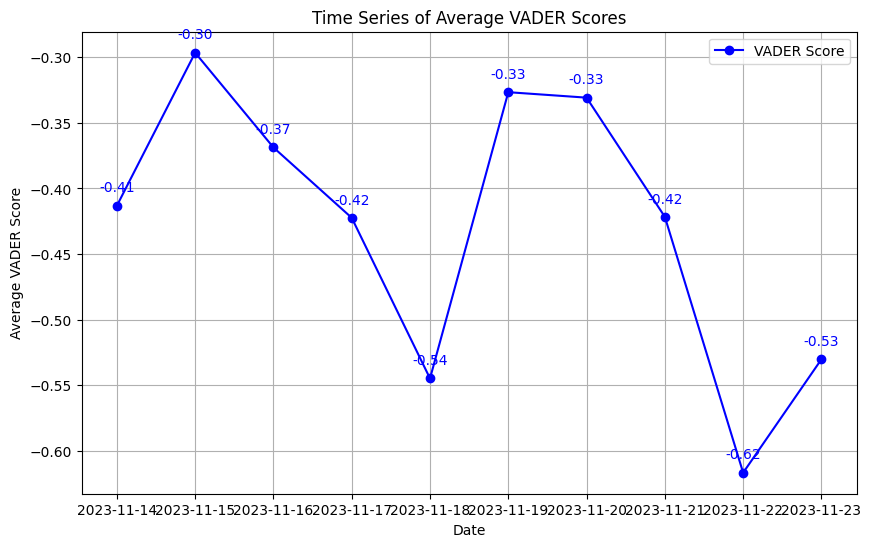

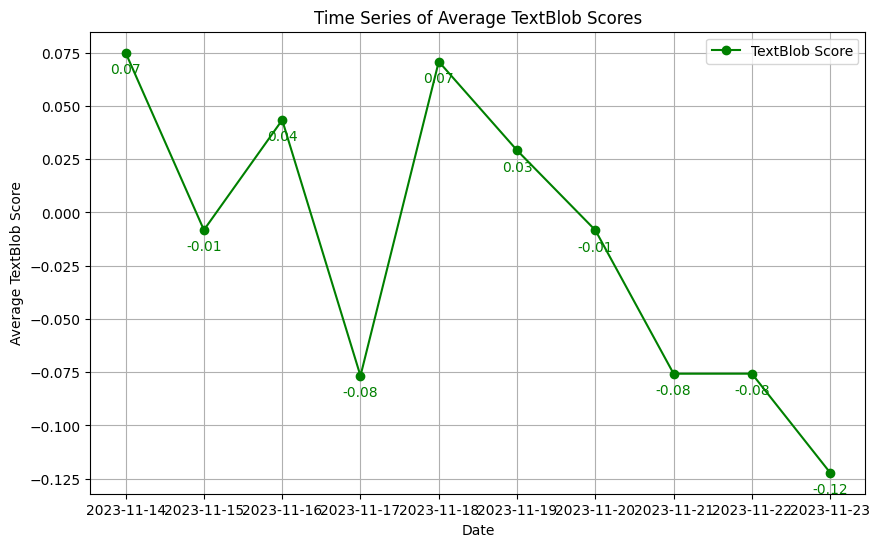

In [38]:
# Group by 'DateOnly' and calculate the average scores
avg_scores = df.groupby('DateOnly').agg({'VADER_Score': 'mean', 'TextBlob_Score': 'mean'}).reset_index()

# Plot the time series graph for VADER Score
plt.figure(figsize=(10, 6))
plt.plot(avg_scores['DateOnly'], avg_scores['VADER_Score'], marker='o', label='VADER Score', color='blue')
plt.xlabel('Date')
plt.ylabel('Average VADER Score')
plt.title('Time Series of Average VADER Scores')
plt.legend()
plt.grid(True)

# Add average score annotations for each point
for i, txt in enumerate(avg_scores['VADER_Score']):
    plt.annotate(f'{txt:.2f}', (avg_scores['DateOnly'].iloc[i], avg_scores['VADER_Score'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')

# Show the plot for VADER Score
plt.show()

# Plot the time series graph for TextBlob Score
plt.figure(figsize=(10, 6))
plt.plot(avg_scores['DateOnly'], avg_scores['TextBlob_Score'], marker='o', label='TextBlob Score', color='green')
plt.xlabel('Date')
plt.ylabel('Average TextBlob Score')
plt.title('Time Series of Average TextBlob Scores')
plt.legend()
plt.grid(True)

# Add average score annotations for each point
for i, txt in enumerate(avg_scores['TextBlob_Score']):
    plt.annotate(f'{txt:.2f}', (avg_scores['DateOnly'].iloc[i], avg_scores['TextBlob_Score'].iloc[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='green')

# Show the plot for TextBlob Score
plt.show()


In [39]:
df.head(20)

,Headline,Date,VADER_Sentiment,VADER_Score,TextBlob_Sentiment,TextBlob_Score,DateOnly
0,"Teen dead, man wounded in Tribeca street stabb...",2023-11-23 19:52:06,negative,-0.8126,negative,-0.266667,2023-11-23
1,"Ex-con shoots Astoria building super, then ope...",2023-11-23 19:53:44,positive,0.3612,positive,0.333333,2023-11-23
2,ATV rider fatally struck by hit-and-run Jeep d...,2023-11-22 19:31:26,negative,-0.7351,positive,0.000000,2023-11-22
3,Cops hunt stranger who groped 12-year-old girl...,2023-11-22 17:27:56,positive,0.0000,positive,0.000000,2023-11-22
4,Teen choked unconscious on Queens subway train...,2023-11-23 00:54:00,negative,-0.7351,positive,0.000000,2023-11-23
5,Ex-diplomat accused of hurling hate words at N...,2023-11-22 18:17:27,negative,-0.7096,negative,-0.800000,2023-11-22
6,"Long Island woman, 23, killed in LIE drunk dri...",2023-11-22 16:16:12,negative,-0.7717,negative,-0.010000,2023-11-22
7,Chronic alcohol abuse blamed for death of real...,2023-11-22 16:18:29,negative,-0.9477,negative,-0.100000,2023-11-22
8,Brooklyn man was ‘sickly’ and no threat to cou...,2023-11-21 20:19:51,negative,-0.8720,negative,-0.329762,2023-11-21
9,Judge set to release two Gambino soldiers for ...,2023-11-21 18:08:12,positive,0.5448,positive,0.000000,2023-11-21
